**Section 1: Preparing Data**

##Generating Data in required format##

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pickle
import regex as re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split

**ICD code**

In [3]:
def convert_to_icd9(dx_str):
    """
    Maps an ICD diagnosis code to ICD9
    """

    if dx_str.startswith("E"):
        if len(dx_str) > 4:
            return dx_str[:4] + "." + dx_str[4:]
        else:
            return dx_str

    elif dx_str.startswith("V"):
        if len(dx_str) > 4:
            return dx_str[:4] + "." + dx_str[4:]
        else:
            return dx_str

    else:
        if len(dx_str) > 3:
            return dx_str[:3] + "." + dx_str[3:]
        else:
            return dx_str

For different ICD9 codes, the output generated by above function will be as shown below

In [4]:
print(convert_to_icd9('49320'))
print(convert_to_icd9('250'))
print(convert_to_icd9('E8504'))
print(convert_to_icd9('E950'))
print(convert_to_icd9('V750'))

493.20
250
E850.4
E950
V750


In [5]:
def convert_to_3digit_icd9(dx_str):
    """
    Roll up a diagnosis code to 3 digits
    """

    if dx_str.startswith("E"):
        if len(dx_str) > 4:
            return dx_str[:4]
        else:
            return dx_str

    elif dx_str.startswith("V"):
        if len(dx_str) > 4:
            # Handle "V"-codes
            return dx_str[:4] + "." + dx_str[4:]
        else:
            return dx_str

    else:
        if len(dx_str) > 3:
            return dx_str[:3]
        else:
            return dx_str

For different ICD9 codes, the output generated by above function in 3 digit format will be as shown below

In [6]:
print(convert_to_3digit_icd9('49320'))
print(convert_to_3digit_icd9('250'))
print(convert_to_3digit_icd9('E8504'))
print(convert_to_3digit_icd9('E950'))
print(convert_to_icd9('V750'))

493
250
E850
E950
V750


**Patients Table to Collect Mortality**


In [7]:
# Define the paths to your CSV files in the "MIMIC" folder in your Colab environment
admission_file = "/content/drive/MyDrive/MIMIC/ADMISSIONS.csv"
diagnosis_file = "/content/drive/MyDrive/MIMIC/DIAGNOSES_ICD.csv"
patients_file = "/content/drive/MyDrive/MIMIC/PATIENTS.csv"
out_directory = "/content/drive/MyDrive/MIMIC/output"
train_proportion = 0.8  # Modify the train proportion as needed

This code reads `PATIENTS.csv` containing patient data, specifically looking for information related to the date of death in the hospital. It then stores this information in a dictionary, indicating whether each patient has a recorded date of death or not.

In [8]:
# Read mortality data
print("Collecting mortality information...")
pid_dod_map = {}
infd = open(patients_file, "r")
infd.readline()
for line in infd:
    tokens = line.strip().split(",")
    pid = int(tokens[1])
    dod_hosp = tokens[5]
    if len(dod_hosp) > 0:
        pid_dod_map[pid] = 1
    else:
        pid_dod_map[pid] = 0
infd.close()

In [9]:
#print five data to check whether the patient is dead or alive. 0 stands for alive and 1 stands for dead
# output is in the form patientId: dead/alive
pid_death_status_pairs = {k: pid_dod_map[k] for k in list(pid_dod_map)[:10]}
pid_death_status_pairs

{249: 0,
 250: 1,
 251: 0,
 252: 0,
 253: 0,
 255: 0,
 256: 0,
 257: 1,
 258: 0,
 260: 0}

**Section 2: Building mappings and chronological visit**

**Admissions Table to Build patient-admission mapping and admission-date mappping**

This code reads `ADMISSIONS.csv` data file and creates two mappings: one for patients and their corresponding admission records and another for admission IDs and their admission dates. These mappings are useful for organizing and accessing patient admission information efficiently

In [10]:
# Read and create admission records
print("Building pid-admission mapping, admission-date mapping...")
pid_adm_map = {}
adm_date_map = {}
infd = open(admission_file, "r")
infd.readline()
for line in infd:
    tokens = line.strip().split(",")
    pid = int(tokens[1])
    adm_id = int(tokens[2])
    adm_time = datetime.strptime(tokens[3], "%Y-%m-%d %H:%M:%S")
    adm_date_map[adm_id] = adm_time
    if pid in pid_adm_map:
        pid_adm_map[pid].append(adm_id)
    else:
        pid_adm_map[pid] = [adm_id]
infd.close()

Building pid-admission mapping, admission-date mapping...


In [11]:
#print 10 data to check what was the hospital admission ids for patients
# output is in the form patientId: hospital admission id (multiple values represent multiple hospital admission id)
pid_hadmid_pairs = {k: pid_adm_map[k] for k in list(pid_adm_map)[15:25]}
pid_hadmid_pairs

{38: [185910],
 39: [106266],
 41: [101757],
 357: [174486, 145674, 122609, 101651, 117876],
 358: [110872],
 359: [144265],
 360: [154871],
 361: [108205, 148959],
 362: [142749, 150873],
 363: [196503]}

**Diagnosis_ICD Table to connect mappings with disgnosis codes**

This code reads a `DIAGNOSIS_ICD.csv` file and creates two mappings that associate admission IDs with diagnosis codes. One mapping stores the codes in ICD-9 format with periods, and the other stores them in a simplified 3-digit ICD-9 format. These mappings are useful for organizing and accessing patient diagnosis information efficiently.

In [12]:
# Create admission dx code mapping
print("Building admission-dxList mapping...")
adm_dx_map = {}
adm_dx_map_3digit = {}
infd = open(diagnosis_file, "r")
infd.readline()
for line in infd:
    tokens = re.sub('"|\s|\n','',line).split(',')
    adm_id = int(tokens[2])
    dx_str = "D_" + convert_to_icd9(tokens[4])
    dx_str_3digit = "D_" + convert_to_3digit_icd9(tokens[4])
    if adm_id in adm_dx_map:
        adm_dx_map[adm_id].append(dx_str)
    else:
        adm_dx_map[adm_id] = [dx_str]
    if adm_id in adm_dx_map_3digit:
        adm_dx_map_3digit[adm_id].append(dx_str_3digit)
    else:
        adm_dx_map_3digit[adm_id] = [dx_str_3digit]
infd.close()

Building admission-dxList mapping...


In [13]:
# this displays hospital admission id and respective ICD9 codes which are truncated in a fashion as mentioned below
# if you go to DIAGNOSIS_ICD file and check one of the admission id, you will see respective ICD9 codes associated with it
admission_dx_pairs = {k: adm_dx_map[k] for k in list(adm_dx_map)[25:30]}
admission_dx_pairs

{171781: ['D_V300.1', 'D_772.14', 'D_765.18', 'D_765.28', 'D_V053'],
 160192: ['D_430', 'D_780.39', 'D_276.1', 'D_305.1'],
 191817: ['D_410.71',
  'D_414.01',
  'D_496',
  'D_599.0',
  'D_440.0',
  'D_293.9',
  'D_274.9',
  'D_443.9',
  'D_401.9',
  'D_272.0',
  'D_V158.2'],
 167887: ['D_396.3',
  'D_414.01',
  'D_401.9',
  'D_530.81',
  'D_365.9',
  'D_244.9',
  'D_443.9'],
 192180: ['D_135', 'D_349.82', 'D_599.0', 'D_311', 'D_E935.2']}

**Build Chronological Order for Visits and their ICD Codes**

This code creates two mappings that sort patient visits in chronological order. It leverages the admission information and diagnosis codes for each admission to organize visits for each patient. The two mappings provide chronological order information in both ICD-9 and simplified 3-digit ICD-9 formats.

In [14]:
# Create ordered visit mapping
print("Building pid-sortedVisits mapping...")
pid_seq_map = {}
pid_seq_map_3digit = {}
for pid, adm_id_list in pid_adm_map.items():
    if len(adm_id_list) < 2:
        continue
    sorted_list = sorted(
        [(adm_date_map[adm_id], adm_dx_map[adm_id]) for adm_id in adm_id_list]
    )
    pid_seq_map[pid] = sorted_list
    sorted_list_3digit = sorted(
        [
            (adm_date_map[adm_id], adm_dx_map_3digit[adm_id])
            for adm_id in adm_id_list
        ]
    )
    pid_seq_map_3digit[pid] = sorted_list_3digit

Building pid-sortedVisits mapping...


taking example of patient id 112. The patient had 2 admissions. The format is as follows (year, month, date, hour, minute) and ICD9 code diagnosed for that admission

in this example, for first visit on datetime(2194, 6, 13, 18, 39) the ICD9 codes diagnosed were D_531', 'D_410', 'D_285', 'D_414', 'D_725' and

for second visit on datetime(2196, 9, 27, 18, 21) the ICD9 codes diagnosed were 'D_038', 'D_785', 'D_486', 'D_203', 'D_276', 'D_584', 'D_403',  'D_585', 'D_410', 'D_518', 'D_995', 'D_414', 'D_600'

In [15]:
ordered_visiting = {k: pid_seq_map_3digit[k] for k in list(pid_seq_map_3digit)[25:27]}
ordered_visiting

{112: [(datetime.datetime(2194, 6, 13, 18, 39),
   ['D_531', 'D_410', 'D_285', 'D_414', 'D_725']),
  (datetime.datetime(2196, 9, 27, 18, 21),
   ['D_038',
    'D_785',
    'D_486',
    'D_203',
    'D_276',
    'D_584',
    'D_403',
    'D_585',
    'D_410',
    'D_518',
    'D_995',
    'D_414',
    'D_600'])],
 117: [(datetime.datetime(2133, 4, 7, 16, 29),
   ['D_571',
    'D_789',
    'D_070',
    'D_287',
    'D_428',
    'D_285',
    'D_276',
    'D_401',
    'D_250']),
  (datetime.datetime(2133, 11, 13, 21, 34),
   ['D_570',
    'D_070',
    'D_571',
    'D_584',
    'D_572',
    'D_511',
    'D_286',
    'D_518',
    'D_287',
    'D_038',
    'D_486',
    'D_280',
    'D_263',
    'D_276',
    'D_276',
    'D_995',
    'D_303',
    'D_401',
    'D_572',
    'D_250',
    'D_244',
    'D_112'])]}

**Adding mortality lables**

This code assembles lists of patient-related data, including patient IDs, admission dates, sequences of diagnosis codes, and mortality labels. These lists are organized for further analysis or processing in the program.

In [16]:
print("Building pids, dates, mortality_labels, strSeqs...")
pids = []
dates = []
seqs = []
morts = []
for pid, visits in pid_seq_map.items():
    pids.append(pid)
    morts.append(pid_dod_map[pid])
    seq = []
    date = []
    for visit in visits:
        date.append(visit[0])
        seq.append(visit[1])
    dates.append(date)
    seqs.append(seq)

Building pids, dates, mortality_labels, strSeqs...


In [17]:
#for row zero the following details are displayed. Pid, date of admission, diagnosed ICD9_codes for that admission, and whether the patient is dead or alive
row = 0
print('pid:', pids[row])
for i in range(len(dates[row])):
  print(dates[row][i])
  print(seqs[row][i])
print('Dead_or_alive:', morts[row])

pid: 23
2153-09-03 07:15:00
['D_414.01', 'D_411.1', 'D_424.1', 'D_V458.2', 'D_272.4', 'D_401.9', 'D_600.00', 'D_389.9']
2157-10-18 19:34:00
['D_225.2', 'D_348.5', 'D_780.39', 'D_424.1', 'D_401.9', 'D_272.0', 'D_272.4', 'D_V458.1', 'D_V457.9', 'D_V158.2']
Dead_or_alive: 0


**Section 3: ICD coding process**

**Converting ICD9 3-digit to seqs_s digit list**

This code creates sequences of diagnosis codes in a simplified 3-digit ICD-9 format for each patient and stores them in the seqs_3digit list.

In [18]:
# Similarly sequences are created for 3 digit ICD9 code as above
# Create 3 digit ICD sequences
print("Building pids, dates, strSeqs for 3digit ICD9 code...")
seqs_3digit = []
for pid, visits in pid_seq_map_3digit.items():
    seq = []
    for visit in visits:
        seq.append(visit[1])
    seqs_3digit.append(seq)

Building pids, dates, strSeqs for 3digit ICD9 code...


This code converts sequences of diagnosis codes from string format to integer format and maintains a mapping of code types, where each unique diagnosis code is associated with an integer code type.

This integer representation is the **V** vector mentioned in the architecture.

In [19]:
# Collect code types
print("Converting strSeqs to intSeqs, and making types...")
types = {}
new_seqs = []
for patient in seqs:
    new_patient = []
    for visit in patient:
        new_visit = []
        for code in visit:
            if code in types:
                new_visit.append(types[code])
            else:
                types[code] = len(types)
                new_visit.append(types[code])
        new_patient.append(new_visit)
    new_seqs.append(new_patient)

Converting strSeqs to intSeqs, and making types...


the above ICD_9 code is converted into integer values which will be used later in prediction as strings cannot be used directly

it starts with zero and if any code repeats than it is assigned the previous value.

example: D_424.1 (encoded as 2) appears in second position and also in 11 position. Hence 2 is repeated twice. Similarly D_272.4 appears 2 times.

In [20]:
# to show how ICD 9 codes are encoded to integer numbers so that they can be used by model
for i in range(len(dates[row])):
  print(dates[row][i])
  print(seqs[row][i])

2153-09-03 07:15:00
['D_414.01', 'D_411.1', 'D_424.1', 'D_V458.2', 'D_272.4', 'D_401.9', 'D_600.00', 'D_389.9']
2157-10-18 19:34:00
['D_225.2', 'D_348.5', 'D_780.39', 'D_424.1', 'D_401.9', 'D_272.0', 'D_272.4', 'D_V458.1', 'D_V457.9', 'D_V158.2']


In [21]:
new_seqs[row]

[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 2, 5, 11, 4, 12, 13, 14]]

This code is used to find the total number of unique ICD9 codes available in the data

In [22]:
# Flatten the 3-dimensional list into a single list
flat_list = [item for sublist1 in new_seqs for sublist2 in sublist1 for item in sublist2]

# Use set to get unique ICD9 codes (encoded)
unique_numbers = set(flat_list)

# Count the unique codes
count_unique_numbers_icd9 = len(unique_numbers)

print("number of unique ICD9 codes:", count_unique_numbers_icd9)

number of unique ICD9 codes: 4894


In [23]:
#similarly doing same string to integer conversion for 3 digit ICD9 codes (reducing ICD9 codes to only 3 digits)
# Map code strings to integers
print("Converting strSeqs to intSeqs, and making types for 3digit ICD9 code...")
types_3digit = {}
new_seqs_3digit = []
for patient in seqs_3digit:
    new_patient = []
    for visit in patient:
        new_visit = []
        for code in set(visit):
            if code in types_3digit:
                new_visit.append(types_3digit[code])
            else:
                types_3digit[code] = len(types_3digit)
                new_visit.append(types_3digit[code])
        new_patient.append(new_visit)
    new_seqs_3digit.append(new_patient)

Converting strSeqs to intSeqs, and making types for 3digit ICD9 code...


In [24]:
# Flatten the 3-dimensional list into a single list
flat_list = [item for sublist1 in new_seqs_3digit for sublist2 in sublist1 for item in sublist2]

# Use set to get unique numbers
unique_numbers = set(flat_list)

# Count the unique numbers
count_unique_numbers_3icd9 = len(unique_numbers)

print("number of unique 3 digit ICD9 codes:", count_unique_numbers_3icd9)

number of unique 3 digit ICD9 codes: 1272


**Section 4: Processing Date**

Calculates the time difference between a reference date (January 1, 2025) and a list of dates stored in a variable called dates. The result is stored in a variable called to_event and sort the data according to date.

In [25]:
# Compute time to today as to_event column
print("Making additional modifications to the data...")
today = datetime.strptime("2025-01-01", "%Y-%m-%d")
to_event = [[(today - date).days for date in patient] for patient in dates]

Making additional modifications to the data...


For each date in a patient's record, it calculates a numeric value using the formula: `date.hour * 60 + date.minute - 720`.

   - `date.hour` returns the hour part of the date in minutes (e.g., 9 AM would be 540 minutes).
   - `date.minute` returns the minute part of the date.
   - Subtracting 720 represents the offset from noon (720 minutes) to obtain values that can be positive or negative.

The result is a 2D list where each inner list corresponds to a patient's dates, and each element within an inner list is a numeric value based on the calculation explained above.

For example, if `dates` contains something like this:

```python
dates = [[datetime(2023, 10, 25, 9, 30), datetime(2023, 10, 25, 14, 15)], [datetime(2023, 10, 25, 8, 0), datetime(2023, 10, 25, 11, 45)]]
```

The `numerics` variable would be calculated as follows:

```python
numerics = [[-150, 135], [-240, -15]]
```

In this example, the code calculates the numeric values based on the hour and minute of each datetime object, with an offset from noon (720 minutes).

In [26]:
# Compute time of the day when the person was admitted as the numeric column of size 1 and then it sorts based on time
numerics = [
    [[date.hour * 60 + date.minute - 720] for date in patient] for patient in dates
]
# Add this feature to dictionary but leave 1 index empty for PADDING
types["Time of visit"] = len(types) + 1
types_3digit["Time of visit"] = len(types_3digit) + 1
# Compute sorting indicies
sort_indicies = np.argsort(list(map(len, to_event)))

**Creating Dataframes**

This code constructs three dataframes from various data sources and sorts them based on the number of visits per patient.

`all_data` contains ICD9 codes, `all_data_3digit` contains ICD9 codes in with sequences of diagnosis codes in a simplified 3-digit ICD-9 format. `all_targets` contains target variables (dead or alive)

In [27]:
# Create the dataframes of data and sort them according to number of visits per patient
print("Building sorted dataframes...")
all_data = (
    pd.DataFrame(
        data={"codes": new_seqs, "to_event": to_event, "numerics": numerics},
        columns=["codes", "to_event", "numerics"],
    )
    .iloc[sort_indicies]
    .reset_index()
)
all_data_3digit = (
    pd.DataFrame(
        data={"codes": new_seqs_3digit, "to_event": to_event, "numerics": numerics},
        columns=["codes", "to_event", "numerics"],
    )
    .iloc[sort_indicies]
    .reset_index()
)
all_targets = (
    pd.DataFrame(data={"target": morts}, columns=["target"])
    .iloc[sort_indicies]
    .reset_index()
)

Building sorted dataframes...


The below data frame has the following features.
index represents row number before sorting,
codes are icd9 codes after changing to integer values

to_events represent date with respect to reference (Jan 01 2025)

numerics are time of admission with respect to a reference time (12 noon).

In [28]:
# row number before they were ordered chronologically. This column is not used for any ML task
all_data.head()

,index,codes,to_event,numerics
0,0,"[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 2, 5, 11...","[-46997, -48503]","[[-285], [454]]"
1,4691,"[[670], [1879, 5, 4]]","[-56002, -56038]","[[-150], [-285]]"
2,4690,"[[62, 23, 966, 20, 16, 403, 18, 54, 315, 149],...","[-51247, -52844]","[[-95], [580]]"
3,4688,"[[101, 103, 59, 1496, 1812, 105, 0, 2, 285, 6,...","[-61255, -62614]","[[-509], [-588]]"
4,4687,"[[62, 17, 23, 92, 16, 18, 0, 331, 91, 2124, 24...","[-49887, -49907]","[[50], [306]]"


In [29]:
#similarly for 3 digit ICD9 code
all_data_3digit.head()

,index,codes,to_event,numerics
0,0,"[[0, 1, 2, 3, 4, 5, 6, 7], [8, 1, 2, 3, 9, 10,...","[-46997, -48503]","[[-285], [454]]"
1,4691,"[[139], [357, 1, 2]]","[-56002, -56038]","[[-150], [-285]]"
2,4690,"[[14, 15, 69, 193, 16, 38, 17, 73], [14, 24, 6...","[-51247, -52844]","[[-95], [580]]"
3,4688,"[[74, 24, 3, 4, 78, 10, 5, 79, 52, 132], [58, ...","[-61255, -62614]","[[-509], [-588]]"
4,4687,"[[14, 172, 15, 328, 202, 263, 55, 4, 67, 17, 3...","[-49887, -49907]","[[50], [306]]"


In [30]:
#target column
all_targets.head() # 0 represents alive, 1 represents dead

,index,target
0,0,0
1,4691,0
2,4690,0
3,4688,1
4,4687,0


**Section 5: Data Imbalancing**

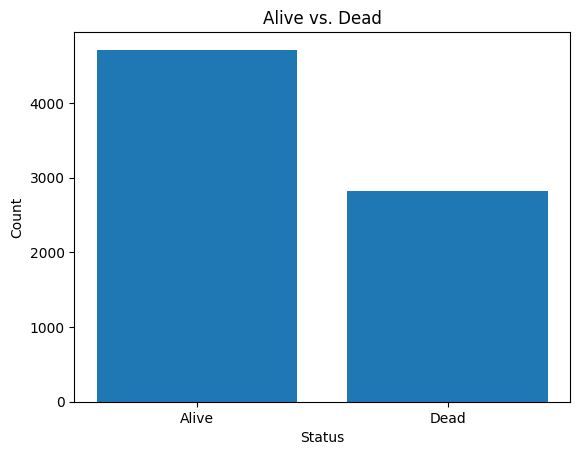

In [31]:
#plotting distribution of how many patients are dead and how many are alive

import matplotlib.pyplot as plt
# Count the occurrences of 'alive' (0) and 'dead' (1)
status_counts = all_targets['target'].value_counts()

# Create a bar plot
plt.bar(status_counts.index, status_counts.values)

# Customize the plot
plt.title('Alive vs. Dead')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Alive', 'Dead'])

# Show the plot
plt.show()

This code is focused on balancing the class distribution by undersampling the majority class. It aims to address class imbalance, where one class (the minority class) has significantly fewer samples than the other class (the majority class).

In [32]:
#Balancing the class distribution using undersampling. Undersampling showed lower accuracy of the model, but the caliberation is better

# Count the occurrences of each class
class_counts = all_targets['target'].value_counts()

# Find the minority class label (1 in this case)
minority_class = class_counts.idxmin()

# Calculate the number of samples in the minority class
minority_count = class_counts[minority_class]

# Find the indices of the majority class samples (0 in this case)
majority_indices = all_targets[all_targets['target'] == 0].index

# Randomly select a subset of majority class indices to match the minority class count
undersampled_majority_indices = np.random.choice(majority_indices, size=minority_count, replace=False)

# Concatenate the minority class indices with the undersampled majority class indices
undersampled_indices = pd.Index(undersampled_majority_indices).union(all_targets[all_targets['target'] == 1].index)

# Create the balanced DataFrames
all_data = all_data.loc[undersampled_indices].reset_index(drop=True)
all_data_3digit = all_data_3digit.loc[undersampled_indices].reset_index(drop=True)
all_targets = all_targets.loc[undersampled_indices].reset_index(drop=True)

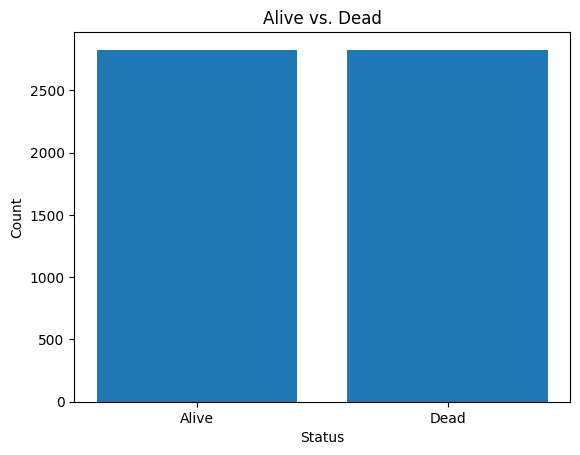

In [33]:
#plotting distribution of how many patients are dead and how many are alive

import matplotlib.pyplot as plt
# Count the occurrences of 'alive' (0) and 'dead' (1)
status_counts = all_targets['target'].value_counts()

# Create a bar plot
plt.bar(status_counts.index, status_counts.values)

# Customize the plot
plt.title('Alive vs. Dead')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Alive', 'Dead'])

# Show the plot
plt.show()

**Section 6: Training and Test datasets**

Spits data into training and test data. Training data is used in training the model and test data is the unseen data on which model will predict

In [35]:
# Create train test split, train_proportion=0.8
# in section 1 after printing converted ICD9 codes
print("Creating train/test splits...")
data_train, data_test = train_test_split(
    all_data, train_size=train_proportion, random_state=12345
)
data_train_3digit, data_test_3digit = train_test_split(
    all_data_3digit, train_size=train_proportion, random_state=12345
)
target_train, target_test = train_test_split(
    all_targets, train_size=train_proportion, random_state=12345
)

Creating train/test splits...


Training data

In [36]:
data_train.head()

,index,codes,to_event,numerics
2515,1238,"[[16, 199, 874, 434, 357, 330, 1673, 90, 92], ...","[-64309, -64326]","[[418], [544]]"
822,3250,"[[46, 363, 45, 366, 39, 84, 321, 36, 61], [352...","[-34366, -34798]","[[181], [-325]]"
5129,3746,"[[50, 15, 16, 42, 51, 18, 97, 115, 358, 310, 4...","[-40811, -42451, -42999, -43009]","[[-402], [545], [526], [515]]"
5611,7487,"[[1943, 61, 15, 445, 150, 23, 2335, 16, 1473, ...","[-31755, -31796, -31869, -31874, -32305, -3235...","[[396], [-55], [153], [-64], [91], [392], [366..."
3969,1030,"[[411, 971, 1083, 682, 48, 598, 103, 342, 126,...","[-33192, -33200, -33228]","[[-649], [479], [709]]"


In [37]:
target_train.head()

,index,target
2515,1238,1
822,3250,1
5129,3746,1
5611,7487,0
3969,1030,0


Test data

In [38]:
data_test.head()

,index,codes,to_event,numerics
912,4036,"[[896, 2129, 2055, 486, 855, 487, 948, 2197, 2...","[-36343, -36441]","[[339], [407]]"
2620,2139,"[[1397, 750, 483, 46, 365, 1068], [1259, 363, ...","[-63407, -64492]","[[-497], [705]]"
2480,1309,"[[34, 18, 1320, 5], [127, 18, 17, 2049, 61, 69...","[-38384, -38894]","[[-172], [675]]"
5278,2499,"[[16, 18, 54, 91, 5, 3, 331], [139, 61, 16, 12...","[-32379, -32394, -33233, -33246, -33335]","[[449], [-713], [-553], [-1], [629]]"
554,5061,"[[179, 753, 139, 103, 894, 143, 5, 462, 1101],...","[-51862, -52934]","[[-195], [154]]"


In [39]:
target_test.head()

,index,target
912,4036,0
2620,2139,0
2480,1309,1
5278,2499,1
554,5061,1


Since recent visits are given more priority. The below code reverses the visits based on chronological order

In [40]:
# Create reverse dictionary in index:code format
# because RNN takes data in reverse order taking most recent visit first (as the paper says, doctors rely more on recent data)
types = dict((v, k) for k, v in types.items())
types_3digit = dict((v, k) for k, v in types_3digit.items())

In [41]:
# Write out the data
print("Saving data...")
if not os.path.exists(out_directory):
    os.makedirs(out_directory)
data_train.sort_index().to_pickle(out_directory + "/data_train.pkl")
data_test.sort_index().to_pickle(out_directory + "/data_test.pkl")
data_train_3digit.sort_index().to_pickle(out_directory + "/data_train_3digit.pkl")
data_test_3digit.sort_index().to_pickle(out_directory + "/data_test_3digit.pkl")
target_train.sort_index().to_pickle(out_directory + "/target_train.pkl")
target_test.sort_index().to_pickle(out_directory + "/target_test.pkl")
pickle.dump(types, open(out_directory + "/dictionary.pkl", "wb"), -1)
pickle.dump(types_3digit, open(out_directory + "/dictionary_3digit.pkl", "wb"), -1)

Saving data...


**Section 7: Setting up training model**

##Training model##

In [42]:
import os
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import non_neg, Constraint
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

This code defines a set of global configuration parameters with default values. These parameters are often used in machine learning or deep learning models to configure various aspects of the model's architecture and training process. These global variables allow for easy configuration of various parameters when working with machine learning or deep learning models, and they can be adjusted as needed for different experiments

In [43]:
# Define global variables for configuration parameters with default values
# these are variables which are hyperparameters. Hyperparameters include epochs, size of recurrent unit, batch size used while training and testing, dropout to reduce overfitting, etc
NUM_CODES = count_unique_numbers_icd9 + count_unique_numbers_3icd9 # total number of unique ICD9 codes
NUMERIC_SIZE = 0
USE_TIME = False
EMB_SIZE = 200
EPOCHS = 1
N_STEPS = 300
RECURRENT_SIZE = 200
PATH_DATA_TRAIN = "/content/drive/MyDrive/MIMIC/output/data_train.pkl"  # Replace with your file path
PATH_DATA_TEST = "/content/drive/MyDrive/MIMIC/output/data_test.pkl"  # Replace with your file path
PATH_TARGET_TRAIN = "/content/drive/MyDrive/MIMIC/output/target_train.pkl"  # Replace with your file path
PATH_TARGET_TEST = "/content/drive/MyDrive/MIMIC/output/target_test.pkl"  # Replace with your file path
BATCH_SIZE = 32
DROPOUT_INPUT = 0.0
DROPOUT_CONTEXT = 0.0
L2 = 0.0
DIRECTORY = "/content/drive/MyDrive/MIMIC/output/Model"  # Replace with your file path
ALLOW_NEGATIVE = False

**Further processing data sequences**

The SequenceBuilder class is designed to facilitate the construction of data sequences for training deep learning models, considering different data types and providing batched data suitable for training. It also handles data padding to ensure uniform shapes within batches.

The class extends the Sequence class provided by TensorFlow.

In [44]:
# computes length so that if there is dimension mismatch, then it pads with zeros
class SequenceBuilder(Sequence):
    """
    Class to properly construct data into sequences prior to training.

    :param Sequence: Customized Sequence class for generating batches of data
    :type Sequence: :class:`tensorflow.keras.utils.Sequence`
    :returns: Padded, dense data used for Sequence construction (codes,visits,numerics)
    :rtype: :class:`ndarray`
    """

    def __init__(self, data, target, batch_size, target_out=True):
        """
        Instantiates the code.

        :param data: Training data sequences (codes, visits, numerics)
        :type data: list[:class:`ndarray`]
        :param target: List of target values
        :type target: :class:`numpy.ndarray`
        :param batch_size: Number of samples in each batch
        :type batch_size: int
        :param target_out: If `True` (default), then return the target values
        :type target_out: bool
        :returns: data sequences (codes, visits, numerics)
        :rtype: list[:class:`ndarray`]
        """

        # Receive all appropriate data
        self.codes = data[0]
        index = 1
        if NUMERIC_SIZE:
            self.numeric = data[index]
            index += 1

        if USE_TIME:
            self.time = data[index]

        self.num_codes = NUM_CODES
        self.target = target
        self.batch_size = batch_size
        self.target_out = target_out
        self.numeric_size = NUMERIC_SIZE
        self.use_time = USE_TIME
        self.n_steps = N_STEPS
        # self.balance = (1-(float(sum(target))/len(target)))/(float(sum(target))/len(target))

    def __len__(self):
        """
        Compute number of batches.
        Add extra batch if the data doesn't exactly divide into batches

        :return: Number of batches per epoch
        :rtype: int
        """

        if len(self.codes) % self.batch_size == 0:
            return len(self.codes) // self.batch_size
        return len(self.codes) // self.batch_size + 1

    def __getitem__(self, idx):
        """
        Get batch of specific index.

        :param idx: The index number for the batch to return
        :type idx: int
        :return: Padded data sequences (codes, visits, numerics)
        :rtype: list[:class:`ndarray`]
        """

        def pad_data(data, length_visits, length_codes, pad_value=0):
            """
            Pad numpy array to shift sparse matrix to dense matrix

            :param data: Training data sequences (codes, visits, numerics)
            :type data: list[:class:`ndarray`]
            :param int length_visits: max visit count in batch
            :param int length_codes: max codes length in batch
            :param pad_value: numeric value to represent padding, defaults to 0
            :type pad_value: int, optional
            :return: 'dense' array with padding for codes and visits
            :rtype: :class:`numpy.ndarray`
            """

            zeros = np.full((len(data), length_visits, length_codes), pad_value)
            for steps, mat in zip(data, zeros):
                if steps != [[-1]]:
                    for step, mhot in zip(steps, mat[-len(steps) :]):
                        # Populate the data into the appropriate visit
                        mhot[: len(step)] = step

            return zeros

        # Compute reusable batch slice
        batch_slice = slice(idx * self.batch_size, (idx + 1) * self.batch_size)
        x_codes = self.codes[batch_slice]
        # Max number of visits and codes inside the visit for this batch
        pad_length_visits = min(max(map(len, x_codes)), self.n_steps)
        pad_length_codes = max(map(lambda x: max(map(len, x)), x_codes))
        # Number of elements in a batch (useful in case of partial batches)
        length_batch = len(x_codes)
        # Pad data
        x_codes = pad_data(x_codes, pad_length_visits, pad_length_codes, self.num_codes)
        outputs = [x_codes]
        # Add numeric data if necessary
        if self.numeric_size:
            x_numeric = self.numeric[batch_slice]
            x_numeric = pad_data(x_numeric, pad_length_visits, self.numeric_size, -99.0)
            outputs.append(x_numeric)
        # Add time data if necessary
        if self.use_time:
            x_time = sequence.pad_sequences(
                self.time[batch_slice],
                dtype=np.float32,
                maxlen=pad_length_visits,
                value=+99,
            ).reshape(length_batch, pad_length_visits, 1)
            outputs.append(x_time)

        # Add target if necessary (training vs validation)
        if self.target_out:
            target = self.target[batch_slice].reshape(length_batch, 1, 1)
            # sample_weights = (target*(self.balance-1)+1).reshape(length_batch, 1)
            # In our experiments sample weights provided worse results
            return (outputs, target)

        return outputs

This code defines a custom constraint class named `FreezePadding_Non_Negative`. This constraint is designed to modify the weights of a neural network layer such that the weights in the last layer is "frozen" to be near 0, while permitting negative weights.

In [45]:
class FreezePadding_Non_Negative(Constraint):
    """
    Freezes the last weight to be near 0 - permit negative weights.

    :param Constraint: Keras sequence constraint
    :type Constraint: :class:`tensorflow.keras.constraints.Constraint`
    :return: padded tensor or variable
    :rtype: :class:`tensorflow.Tensor`
    """

    def __call__(self, w):
        other_weights = K.cast(K.greater_equal(w, 0)[:-1], K.floatx())
        last_weight = K.cast(
            K.equal(K.reshape(w[-1, :], (1, K.shape(w)[1])), 0.0), K.floatx()
        )
        appended = K.concatenate([other_weights, last_weight], axis=0)
        w *= appended
        return w

This code defines another custom constraint class named `FreezePadding`, which is similar in spirit to the `FreezePadding_Non_Negative` constraint class. However, there is a key difference: this constraint class does not permit negative weights, and it also aims to freeze the last weight to be near 0.

In [46]:
class FreezePadding(Constraint):
    """
    Freezes the last weight to be near 0 - don't permit negative weights.

    :param Constraint: Keras sequence constraint
    :type Constraint: :class:`tensorflow.keras.constraints.Constraint`
    :return: padded tensor or variable
    :rtype: :class:`tensorflow.Tensor`
    """

    def __call__(self, w):
        other_weights = K.cast(K.ones(K.shape(w))[:-1], K.floatx())
        last_weight = K.cast(
            K.equal(K.reshape(w[-1, :], (1, K.shape(w)[1])), 0.0), K.floatx()
        )
        appended = K.concatenate([other_weights, last_weight], axis=0)
        w *= appended
        return w

This function is used to read and organize training and testing data, along with their associated target labels, into appropriate data structures

In [47]:
def read_data():
    """Read the data from provided paths and assign it into lists"""

    data_train_df = pd.read_pickle(PATH_DATA_TRAIN)
    data_test_df = pd.read_pickle(PATH_DATA_TEST)
    y_train = pd.read_pickle(PATH_TARGET_TRAIN)["target"].values
    y_test = pd.read_pickle(PATH_TARGET_TEST)["target"].values
    data_output_train = [data_train_df["codes"].values]
    data_output_test = [data_test_df["codes"].values]

    if NUMERIC_SIZE:
        data_output_train.append(data_train_df["numerics"].values)

    if USE_TIME:
        data_output_train.append(data_train_df["to_event"].values)

    return (data_output_train, y_train, data_output_test, y_test)

**Section 8: Creating Retain Model**

The `model_create` function is responsible for creating a Keras model using the TensorFlow library. This model is designed to mimic the RETAIN architecture and is used for training and prediction.

The architecture of this model follows the RETAIN architecture and is suitable for binary classification tasks where the goal is to predict binary outcomes. The model uses attention mechanisms to weigh the importance of different elements in the input data. It can handle different types of input data, including codes, numerics, and time, and make predictions based on these inputs. The use of bidirectional LSTMs and attention mechanisms is a key characteristic of the RETAIN architecture, which aims to capture sequential dependencies in the data.

In [48]:
def model_create():
    """
    Create tensorflow DAG for training a model, and then compile/train
    the model at the end.

    :return: trained/compiled Keras model
    :rtype: :class:`tensorflow.keras..Model`
    """

    def retain():
        """
        Helper function to create DAG of Keras Layers via functional API approach.
        The Keras Layer design is mimicking RETAIN architecture.
        :return: Keras model
        :rtype: :class:`tensorflow.keras.Model`
        """

        # Define the constant for model saving
        reshape_size = EMB_SIZE + NUMERIC_SIZE
        if ALLOW_NEGATIVE:
            embeddings_constraint = FreezePadding()
            beta_activation = "tanh"
            output_constraint = None
        else:
            embeddings_constraint = FreezePadding_Non_Negative()
            beta_activation = "sigmoid"
            output_constraint = non_neg()

        def reshape(data):
            """Reshape the context vectors to 3D vector"""
            return K.reshape(x=data, shape=(K.shape(data)[0], 1, reshape_size))

        # Code Input
        codes = L.Input((None, None), name="codes_input")
        inputs_list = [codes]
        # Calculate embedding for each code and sum them to a visit level
        codes_embs_total = L.Embedding(
            NUM_CODES + 1, EMB_SIZE, name="embedding"
        )(codes)
        codes_embs = L.Lambda(lambda x: K.sum(x, axis=2))(codes_embs_total)
        # Numeric input if needed
        if NUMERIC_SIZE:
            numerics = L.Input((None, NUMERIC_SIZE), name="numeric_input")
            inputs_list.append(numerics)
            full_embs = L.concatenate([codes_embs, numerics], name="catInp")
        else:
            full_embs = codes_embs

        # Apply dropout on inputs
        full_embs = L.Dropout(DROPOUT_INPUT)(full_embs)

        # Time input if needed
        if USE_TIME:
            time = L.Input((None, 1), name="time_input")
            inputs_list.append(time)
            time_embs = L.concatenate([full_embs, time], name="catInp2")
        else:
            time_embs = full_embs


        alpha = L.Bidirectional(
            L.LSTM(RECURRENT_SIZE, return_sequences=True, implementation=2),
            name="alpha",
        )
        beta = L.Bidirectional(
            L.LSTM(RECURRENT_SIZE, return_sequences=True, implementation=2),
            name="beta",
        )

        alpha_dense = L.Dense(1, kernel_regularizer=l2(L2))
        beta_dense = L.Dense(
            EMB_SIZE + NUMERIC_SIZE,
            activation=beta_activation,
            kernel_regularizer=l2(L2),
        )

        # Compute alpha, visit attention
        alpha_out = alpha(time_embs)
        alpha_out = L.TimeDistributed(alpha_dense, name="alpha_dense_0")(alpha_out)
        alpha_out = L.Softmax(name="softmax_1", axis=1)(alpha_out)
        # Compute beta, codes attention
        beta_out = beta(time_embs)
        beta_out = L.TimeDistributed(beta_dense, name="beta_dense_0")(beta_out)
        # Compute context vector based on attentions and embeddings
        c_t = L.Multiply()([alpha_out, beta_out, full_embs])
        c_t = L.Lambda(lambda x: K.sum(x, axis=1))(c_t)
        # Reshape to 3d vector for consistency between Many to Many and Many to One implementations
        contexts = L.Lambda(reshape)(c_t)

        # Make a prediction
        contexts = L.Dropout(DROPOUT_CONTEXT)(contexts)
        output_layer = L.Dense(
            1,
            activation="sigmoid",
            name="dOut",
            kernel_regularizer=l2(L2),
            kernel_constraint=output_constraint,
        )

        # TimeDistributed is used for consistency
        # between Many to Many and Many to One implementations
        output = L.TimeDistributed(output_layer, name="time_distributed_out")(contexts)
        # Define the model with appropriate inputs
        model = Model(inputs=inputs_list, outputs=[output])

        return model

    # Set Tensorflow to grow GPU memory consumption instead of grabbing all of it at once
    K.clear_session()
    config = tf.compat.v1.ConfigProto(
        allow_soft_placement=True, log_device_placement=False
    )
    config.gpu_options.allow_growth = True
    tfsess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(tfsess)
    model_final = retain()

    # Compile the model - adamax has produced best results in our experiments
    model_final.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
        sample_weight_mode="temporal",
    )

    return model_final

The `create_callbacks` function is responsible for creating various callback objects that are used during the training of a Keras model. Callbacks are functions that can be applied at different stages during training to perform tasks such as saving model checkpoints, logging training progress, and adjusting the learning rate.

The `LogEval` callback focuses on logging metrics such as `ROC-AUC` and `PR-AUC`, which are common evaluation metrics for binary classification tasks.

In [49]:
def create_callbacks(model, data):
    """At the end of each epoch, determine various callback statistics (e.g. ROC-AUC)

    :param model: Keras model
    :type model: :class:`tensorflow.keras.Model`
    :param data: Validation data - data sequences (codes, visits, numeric values) and classifier.
    :type data: tuple( list( :class:`ndarray`), :class:`ndarray`)
    :param ARGS: Arguments object containing user-specified parameters
    :type ARGS: :class:`argparse.Namespace`
    :return: various callback objects - naming convention for saved HDF5 files, custom logging class, \
    reduced learning rate
    :rtype: tuple(:class:`tensorflow.keras.callbacks.ModelCheckpoint`, :class:`LogEval`, \
    :class:`tensorflow.keras.callbacks.ReduceLROnPlateau`)
    """

    class LogEval(Callback):
        """Logging Callback"""

        def __init__(self, filepath, model, data, interval=1):
            """Constructor for logging class

            :param str filepath: path for log file & Keras HDF5 files
            :param model: model from training used for end-of-epoch analytics
            :type model: :class:`keras.engine.training.Model`
            :param data: Validation data used for end-of-epoch analytics \
            (e.g. data sequences (codes, visits, numerics) and classifier)
            :type data: tuple(list[:class:`ndarray`],:class:`ndarray`)
            :param ARGS: Arguments object containing user-specified parameters
            :type ARGS: :class:`argparse.Namespace`
            :param interval: Interval for logging (e.g. every epoch), defaults to 1
            :type interval: int, optional
            """

            super(Callback, self).__init__()
            self.filepath = filepath
            self.interval = interval
            self.data_test, self.y_test = data
            self.generator = SequenceBuilder(
                data=self.data_test,
                target=self.y_test,
                batch_size=BATCH_SIZE,
                target_out=False,
            )
            self.model = model

        def on_epoch_end(self, epoch, logs={}):

            # Compute ROC-AUC and average precision the validation data every interval epochs
            if epoch % self.interval == 0:

                # Generate predictions
                preds = []
                for x in self.generator:
                    batch_pred = self.model.predict_on_batch(
                        x=x,
                    )
                    preds.append(batch_pred.flatten())
                y_pred = np.concatenate(preds, axis=0)

                # Compute performance
                score_roc = roc_auc_score(self.y_test, y_pred)
                score_pr = average_precision_score(self.y_test, y_pred)

                # Create log file if it doesn't exist, otherwise write to it
                if os.path.exists(self.filepath):
                    append_write = "a"
                else:
                    append_write = "w"
                with open(self.filepath, append_write) as file_output:
                    file_output.write(
                        "\nEpoch: {:d}- ROC-AUC: {:.6f} ; PR-AUC: {:.6f}".format(
                            epoch, score_roc, score_pr
                        )
                    )

                # Print performance
                print(
                    "\nEpoch: {:d} - ROC-AUC: {:.6f} PR-AUC: {:.6f}".format(
                        epoch, score_roc, score_pr
                    )
                )

    # Create callbacks
    if not os.path.exists(DIRECTORY):
        os.makedirs(DIRECTORY)
    checkpoint = ModelCheckpoint(filepath=DIRECTORY + "/weights.{epoch:02d}.hdf5")
    log = LogEval(DIRECTORY + "/log.txt", model, data)
    return (checkpoint, log)

The `train_model` function is responsible for training a Keras model using the provided training data and labels. It also sets up and uses callbacks for monitoring and saving the model during training.

It uses callbacks to monitor and save the model's progress and checkpoints during training. This function is typically used to initiate the training process of a deep learning model.

In [50]:
def train_model(model, data_train, y_train, data_test, y_test):
    """
    Class to hold callback artifacts, Sequence builder of training data, model training
    generator

    :param model: Keras model
    :type model: :class:`tensorflow.keras.Model`
    :param data_train: List with sub-arrays for medical codes, visits, and demographics
    :type data_train: list(:class:`numpy.ndarray`)
    :param y_train: Array with classifiers for training set
    :type y_train: :class:`numpy.ndarray`
    :param data_test: List with sub-arrays for medical codes, visits, and demographics
    :type data_test: list(:class:`numpy.ndarray`)
    :param y_test: Array with classifiers for test set
    :type y_test: :class:`numpy.ndarray`
    """

    checkpoint, log = create_callbacks(model, (data_test, y_test))
    train_generator = SequenceBuilder(
        data=data_train, target=y_train, batch_size=BATCH_SIZE
    )
    model.fit(
        x=train_generator,
        epochs=EPOCHS,
        max_queue_size=15,
        use_multiprocessing=True,
        callbacks=[checkpoint, log],
        verbose=1,
        workers=3,
        initial_epoch=0,
    )

The `model_training` function serves as the main entry point for the training process. It loads data, creates a deep learning model, and initiates the training process using the specified data and model. This function can be called to start training the model for a specific task or dataset.

In [51]:
def model_training():
    """Main function"""
    print("Reading Data...")
    data_train, y_train, data_test, y_test = read_data()

    print("Creating Model...")
    model = model_create()

    print("Training Model...")
    train_model(
        model=model,
        data_train=data_train,
        y_train=y_train,
        data_test=data_test,
        y_test=y_test,
    )

In [52]:
# trained models are stored in google drive in output folder
model_training()

Reading Data...
Creating Model...
Training Model...
142/142 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.6774

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch: 0 - ROC-AUC: 0.820340 PR-AUC: 0.809551
142/142 [==============================] - 46s 219ms/step - loss: 0.5901 - accuracy: 0.6774


**Section 9: Evaluation**

In [53]:
"""RETAIN Model Evaluation"""
import os
import argparse
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.utils import Sequence

In [54]:
# stored in google drive in graphs folder
#Define the file paths and other parameters as constants
PATH_MODEL = "/content/drive/MyDrive/MIMIC/output/Model/weights.01.hdf5"
PATH_DATA = "/content/drive/MyDrive/MIMIC/output/data_test.pkl"
PATH_TARGET = "/content/drive/MyDrive/MIMIC/output/target_test.pkl"
PATH_GRAPH = "/content/drive/MyDrive/MIMIC/output/Graphs/"
OMIT_GRAPHS = True  # Set to True or False as needed
N_STEPS = 300
BATCH_SIZE = 32

The `import_model` function is responsible for loading a previously trained Keras model from an HDF5 file. It allows you to import a trained model to make predictions.

In [55]:
def import_model(path):
    """Import model from training phase

    :param str path: path to HDF5 file
    :return: Keras model
    :rtype: :class:`tensorflow.keras.Model`
    """

    K.clear_session()
    config = tf.compat.v1.ConfigProto(
        allow_soft_placement=True, log_device_placement=False
    )
    config.gpu_options.allow_growth = True
    tfsess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(tfsess)
    model = load_model(
        path,
        custom_objects={
            "FreezePadding": FreezePadding,
            "FreezePadding_Non_Negative": FreezePadding_Non_Negative,
        },
    )

    return model

The `get_model_parameters` function is responsible for extracting and returning various model parameters of interest from a Keras model. These parameters include information about the number of medical codes, numeric features, and the use of time-related data in the model.

In [56]:
def get_model_parameters(model):
    """Get model parameters of interest

    :param model: Keras model
    :type model: :class:`tensorflow.keras.Model`
    :return: parameters of model
    :rtype: :class:`ModelParameters`
    """

    class ModelParameters:
        """Helper class to store model parameters"""

        def __init__(self):
            self.num_codes = None
            self.numeric_size = None
            self.use_time = None

    params = ModelParameters()
    names = [layer.name for layer in model.layers]
    params.num_codes = model.get_layer(name="embedding").input_dim - 1
    if "numeric_input" in names:
        params.numeric_size = model.get_layer(name="numeric_input").input_shape[2]
    else:
        params.numeric_size = 0
    if "time_input" in names:
        params.use_time = True
    else:
        params.use_time = False
    return params

The `precision_recall` function is a valuable tool for assessing the performance of binary classification models, especially in situations involving imbalanced datasets or where the trade-off between precision and recall is crucial.

It provides valuable insights into a model's ability to correctly classify positive instances while minimizing false positives, and the precision-recall curve helps visualize this trade-off.

The purpose of this function is to compute and visualize precision-recall statistics, which can help assess the model's performance, especially in binary classification tasks.

In [57]:
def precision_recall(y_true, y_prob, graph):
    """
    Get precision recall statistics

    :param y_true: NumPy array of true target values
    :type y_true: :class:`numpy.array`
    :param y_prob: NumPy array of predicted target values
    :type y_prob: :class:`numpy.array`
    :param graph: Option to plot + save precision-recall curve
    :type graph: bool
    """

    average_precision = average_precision_score(y_true, y_prob)
    if graph:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        plt.style.use("ggplot")
        plt.clf()
        plt.plot(
            recall,
            precision,
            label="Precision-Recall Curve  (Area = %0.3f)" % average_precision,
        )
        plt.xlabel("Recall: P(predicted+|true+)")
        plt.ylabel("Precision: P(true+|predicted+)")
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc="lower left")
        print("Precision-Recall Curve saved to pr.png")

        # Create the directory if it doesn't exist
        os.makedirs(PATH_GRAPH, exist_ok=True)

        plt.savefig(PATH_GRAPH+"pr.png")
    else:
        print("Average Precision %0.3f" % average_precision)

The `probability_calibration` function is used for probability calibration in classification models.

**Probability Calibration:**
In many classification tasks, especially those involving binary classification, models not only make predictions (e.g., classifying an email as spam or not spam) but also provide probability scores. These probability scores represent the model's confidence in its predictions. For example, a probability score of 0.8 for "spam" suggests the model is 80% confident that the email is spam.

However, these predicted probabilities are not always well-calibrated, meaning they may not accurately reflect the true likelihood of an event occurring. In other words, a model's probability score of 0.8 for "spam" may not mean that 80% of such emails are actually spam. Calibration is the process of ensuring that the predicted probabilities are in line with the actual event probabilities.

**Why Probability Calibration is Important:**
1. **Confidence Estimation:** Calibrated probabilities are useful for understanding how confident the model is in its predictions. This is important for applications where the reliability of predictions matters, such as medical diagnosis.

2. **Threshold Selection:** Many classification tasks require setting a probability threshold for making decisions. For example, in a medical diagnosis model, a threshold might be set to determine when a patient is at high risk. Calibrated probabilities help in selecting appropriate thresholds.

3. **Comparing Models:** Calibration makes it easier to compare the performance of different models. A well-calibrated model provides a more accurate indication of the likelihood of an event happening, making it easier to compare different models or algorithms.

4. **Interpretability:** Calibrated probabilities are more interpretable. Users or stakeholders can better understand the confidence level of the model's predictions, which is essential for transparency and trust.

5. **Graphical Visualization:** The probability calibration curve provides a visual representation of how well the model's predicted probabilities align with the true probabilities. This curve is useful for model evaluation and communication.

**How the Function Works:**
The `probability_calibration` function takes true target values and predicted target probabilities as inputs and offers the option to graphically visualize the calibration. It calculates the fraction of positives and the mean predicted value in specified bins. The calibration curve and histogram of predicted probabilities are plotted for visualization.

The generated calibration plot helps assess whether the model's predicted probabilities are well-calibrated (i.e., closely follow the diagonal dashed line representing perfect calibration) or whether they need further adjustment.

In summary, probability calibration is a crucial step in the evaluation and use of classification models, especially when you need reliable probability estimates. The `probability_calibration` function helps visualize and assess the calibration of your model's predicted probabilities, contributing to better decision-making and model understanding.

In [58]:
def probability_calibration(y_true, y_prob, graph):
    """
    Get probability calibration

    :param y_true: NumPy array of true target values
    :type y_true: :class:`numpy.array`
    :param y_prob: NumPy array of predicted target values
    :type y_prob: :class:`numpy.array`
    :param graph: Option to plot + save probability calibration curves
    :type graph: bool
    """

    if graph:
        fig_index = 1
        name = "My pred"
        n_bins = 20
        fig = plt.figure(fig_index, figsize=(10, 10))
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=n_bins, normalize=True
        )

        ax1.plot(mean_predicted_value, fraction_of_positives, label=name)

        ax2.hist(y_prob, range=(0, 1), bins=n_bins, label=name, histtype="step", lw=2)

        ax1.set_ylabel("Fraction of Positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="lower right")
        ax1.set_title("Calibration Plots  (Reliability Curve)")

        ax2.set_xlabel("Mean predicted value")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)
        print("Probability Calibration Curves saved to calibration.png")
        plt.tight_layout()

        # Create the directory if it doesn't exist
        os.makedirs(PATH_GRAPH, exist_ok=True)

        plt.savefig(PATH_GRAPH+"calibration.png")

The `lift` function is used to create a lift chart for evaluating a classification model.

**Lift Chart:**
A lift chart is a graphical representation of the performance of a binary classification model. It helps assess the model's effectiveness in targeting a specific group, such as potential customers who are likely to respond positively to a marketing campaign.

**Why Lift Chart is Important:**
The lift chart provides insights into how much better the model is at identifying the target group compared to random selection. It is particularly valuable in scenarios where the cost of reaching out to a customer is high (e.g., marketing campaigns) and you want to optimize the use of resources.

**How the Function Works:**
The `lift` function takes the following inputs:

- `y_true`: An array of true target values (e.g., binary labels where 1 represents the positive class).
- `y_prob`: An array of predicted target values (probability scores) from the model.
- `graph`: A boolean parameter that determines whether to create and save a lift chart graph.

The lift chart is constructed as follows:

1. It calculates the prevalence, which is the proportion of positive cases in the dataset (sum of true positives divided by the total number of samples).

2. It computes the average lift by dividing the area under the precision-recall curve by the prevalence.

3. If the `graph` parameter is set to `True`, the function plots the lift-recall curve. The x-axis represents recall (the proportion of actual positives that are correctly predicted as positives), and the y-axis represents lift. The lift is computed as the precision at each recall point divided by the prevalence.

4. The chart may be saved as a file (e.g., "lift.png") in a specified directory.

5. The function can also print the average lift to the console.

**Interpreting the Lift Chart:**
- The lift curve should show whether the model is better than random selection at identifying the target group. The higher the curve, the better the model is at targeting the relevant group.
- The "Area" value in the chart represents the average lift, which indicates the model's overall performance.
- If the area under the curve (AUC) is greater than 1, it means the model is better than random. An AUC of 1 indicates that the model performs the same as random selection.

In summary, the `lift` function is useful for assessing how well a classification model performs at identifying the target group, with a focus on situations where resources should be allocated efficiently. The lift chart provides a visual representation of the model's effectiveness in targeting the desired group, and the average lift value helps in quantifying its performance.

In [59]:
def lift(y_true, y_prob, graph):
    """
    Get lift chart

    :param y_true: NumPy array of true target values
    :type y_true: :class:`numpy.array`
    :param y_prob: NumPy array of predicted target values
    :type y_prob: :class:`numpy.array`
    :param graph: Option to plot + save lift chart
    :type graph: bool
    """

    prevalence = sum(y_true) / len(y_true)
    average_lift = average_precision_score(y_true, y_prob) / prevalence
    if graph:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        lift_values = precision / prevalence
        plt.style.use("ggplot")
        plt.clf()
        plt.plot(
            recall,
            lift_values,
            label="Lift-Recall Curve  (Area = %0.3f)" % average_lift,
        )
        plt.xlabel("Recall: P(predicted+|true+)")
        plt.ylabel("Lift")
        plt.xlim([0.0, 1.0])
        plt.legend(loc="lower left")
        print("Lift-Recall Curve saved to lift.png")

        # Create the directory if it doesn't exist
        os.makedirs(PATH_GRAPH, exist_ok=True)
        plt.savefig(PATH_GRAPH+"lift")
    else:
        print("Average Lift %0.3f" % average_lift)

The `roc` function is used to compute and visualize Receiver Operating Characteristic (ROC) statistics for a binary classification model.

**ROC Analysis:**
- ROC analysis is a technique used to evaluate the performance of a binary classification model.
- It is particularly valuable in situations where you want to assess a model's ability to distinguish between two classes (e.g., positive and negative cases) by varying the model's threshold for classification.

**Why ROC Analysis is Important:**
- ROC analysis provides a comprehensive evaluation of a model's performance across various classification thresholds.
- It helps you understand the trade-off between true positive rate (sensitivity) and false positive rate (1 - specificity) at different threshold settings.
- ROC analysis is especially useful when dealing with imbalanced datasets or when the cost of false positives and false negatives differs.

**How the Function Works:**
The `roc` function takes the following inputs:

- `y_true`: A NumPy array of true target values (e.g., binary labels where 1 represents the positive class).
- `y_prob`: A NumPy array of predicted target values (probability scores) from the model.
- `graph`: A boolean parameter that determines whether to create and save an ROC curve graph.

The ROC analysis is performed as follows:

1. It calculates the ROC-AUC (Area Under the Curve) score, which is a measure of the overall performance of the model. A higher ROC-AUC score indicates better model performance.

2. If the `graph` parameter is set to `True`, the function plots the ROC curve using `matplotlib`. The ROC curve shows the trade-off between sensitivity (true positive rate) and specificity (true negative rate) at various classification thresholds.

3. The function may save the ROC curve as an image file (e.g., "roc.png") in a specified directory.

4. If the `graph` parameter is set to `False`, the function prints the ROC-AUC score to the console.

**Interpreting the ROC Curve:**
- The ROC curve is a plot of true positive rate (sensitivity) against false positive rate (1 - specificity).
- The area under the ROC curve (ROC-AUC) measures the model's ability to distinguish between the two classes. An ROC-AUC score of 0.5 indicates random guessing, while a score of 1.0 represents perfect classification.
- The ROC curve should be above the diagonal line (the line of random guessing) to indicate better-than-random performance.
- The higher the ROC-AUC score, the better the model's performance in distinguishing between positive and negative cases.

In summary, the `roc` function is essential for evaluating the performance of a binary classification model by analyzing its ROC curve and ROC-AUC score. It provides insights into the model's ability to make accurate predictions across different threshold settings and helps in understanding the trade-off between true positives and false positives.

In [60]:
def roc(y_true, y_prob, graph):
    """
    Get ROC statistics

    :param y_true: NumPy array of true target values
    :type y_true: :class:`numpy.array`
    :param y_prob: NumPy array of predicted target values
    :type y_prob: :class:`numpy.array`
    :param graph: Option to plot + save ROC curves
    :type graph: bool
    """

    roc_auc = roc_auc_score(y_true, y_prob)
    if graph:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label="ROC curve (Area = %0.3f)" % roc_auc,
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate (1 - Specifity)")
        plt.ylabel("True Positive Rate (Sensitivity)")
        plt.title("Receiver Operating Characteristic")
        plt.legend(loc="lower right")
        print("ROC Curve saved to roc.png")

        # Create the directory if it doesn't exist
        os.makedirs(PATH_GRAPH, exist_ok=True)

        plt.savefig(PATH_GRAPH+"roc.png")
    else:
        print("ROC-AUC %0.3f" % roc_auc)

Just like `sequenceBuilder` for training, this is used for testing

In [61]:
class SequenceBuilder(Sequence):
    """Class to properly construct data to sequences

    :param Sequence: Customized Sequence class for generating batches of data
    :type Sequence: :class:`tensorflow.keras.utils.data_utils.Sequence`
    """

    def __init__(self, data, model_parameters):
        # Receive all appropriate data
        self.codes = data[0]
        index = 1
        if model_parameters.numeric_size:
            self.numeric = data[index]
            index += 1

        if model_parameters.use_time:
            self.time = data[index]

        self.num_codes = model_parameters.num_codes
        self.batch_size = BATCH_SIZE
        self.numeric_size = model_parameters.numeric_size
        self.use_time = model_parameters.use_time
        self.n_steps = N_STEPS

    def __len__(self):
        """Compute number of batches.
        Add extra batch if the data doesn't exactly divide into batches
        """
        if len(self.codes) % self.batch_size == 0:
            return len(self.codes) // self.batch_size
        return len(self.codes) // self.batch_size + 1

    def __getitem__(self, idx):
        """Get batch of specific index"""

        def pad_data(data, length_visits, length_codes, pad_value=0):
            """Pad data to desired number of visits and codes inside each visit"""
            zeros = np.full((len(data), length_visits, length_codes), pad_value)
            for steps, mat in zip(data, zeros):
                if steps != [[-1]]:
                    for step, mhot in zip(steps, mat[-len(steps) :]):
                        # Populate the data into the appropriate visit
                        mhot[: len(step)] = step

            return zeros

        # Compute reusable batch slice
        batch_slice = slice(idx * self.batch_size, (idx + 1) * self.batch_size)
        x_codes = self.codes[batch_slice]
        # Max number of visits and codes inside the visit for this batch
        pad_length_visits = min(max(map(len, x_codes)), self.n_steps)
        pad_length_codes = max(map(lambda x: max(map(len, x)), x_codes))
        # Number of elements in a batch (useful in case of partial batches)
        length_batch = len(x_codes)
        # Pad data
        x_codes = pad_data(x_codes, pad_length_visits, pad_length_codes, self.num_codes)
        outputs = [x_codes]
        # Add numeric data if necessary
        if self.numeric_size:
            x_numeric = self.numeric[batch_slice]
            x_numeric = pad_data(x_numeric, pad_length_visits, self.numeric_size, -99.0)
            outputs.append(x_numeric)
        # Add time data if necessary
        if self.use_time:
            x_time = sequence.pad_sequences(
                self.time[batch_slice],
                dtype=np.float32,
                maxlen=pad_length_visits,
                value=+99,
            ).reshape(length_batch, pad_length_visits, 1)
            outputs.append(x_time)

        return outputs

This `read_data` function is used to read test dataset. Note that the function defination is different from train dataset

In [62]:
def read_data(model_parameters):
    """Read test data used for scoring

    :param model_parameters: parameters of model
    :type model_parameters: str
    :return: tuple for data and classifier arrays
    :rtype: tuple( list[class:`numpy.ndarray`] , :class:`numpy.ndarray`)
    """

    data = pd.read_pickle(PATH_DATA)
    y = pd.read_pickle(PATH_TARGET)["target"].values
    data_output = [data["codes"].values]

    if model_parameters.numeric_size:
        data_output.append(data["numerics"].values)
    if model_parameters.use_time:
        data_output.append(data["to_event"].values)
    return (data_output, y)

The `get_predictions` function is a useful utility for obtaining predictions from a trained Keras model. It prepares the input data, uses the model to make predictions, and returns the prediction scores. This is valuable for assessing the model's performance, making decisions, or further analysis in a binary classification context.

In [63]:
def get_predictions(model, data, model_parameters):
    """Get Model Predictions

    :param model: trained Keras model
    :type model: :class:`tensorflow.keras.Model`
    :param data: array(s) for features (e.g. ['to_event_ordered','code_ordered','numeric_ordered'])
    :type data: list[class:`numpy.ndarray`]
    :param str model_parameters: parameters of model
    :return: 1-d array of scores for being in positive class
    :rtype: :class:`numpy.ndarray`
    """

    test_generator = SequenceBuilder(data, model_parameters)
    preds = model.predict_generator(
        generator=test_generator,
        max_queue_size=15,
        use_multiprocessing=True,
        verbose=1,
        workers=3,
    )
    return preds

The `model_evaluate` function is a comprehensive tool for evaluating a pre-trained machine learning model. It loads the model, prepares the evaluation data, makes predictions, and assesses the model's performance using various evaluation metrics. If desired, it can generate and save corresponding evaluation plots. This function is essential for understanding how well the model performs on new data and is a critical step in the machine learning model development process.

In [64]:
def model_evaluate():
    """Main Body of the code"""
    print("Loading Model and Extracting Parameters")
    model = import_model(PATH_MODEL)
    model_parameters = get_model_parameters(model)
    print("Reading Data")
    data, y = read_data(model_parameters)
    print("Predicting the probabilities")
    probabilities = get_predictions(model, data, model_parameters)
    print("Evaluating")
    roc(y, probabilities[:, 0, -1], OMIT_GRAPHS)
    precision_recall(y, probabilities[:, 0, -1], OMIT_GRAPHS)
    lift(y, probabilities[:, 0, -1], OMIT_GRAPHS)
    probability_calibration(y, probabilities[:, 0, -1], OMIT_GRAPHS)

Loading Model and Extracting Parameters
Reading Data
Predicting the probabilities


<ipython-input-63-e0641e3deca7>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(


36/36 [==============================] - 2s 9ms/step
Evaluating
ROC Curve saved to roc.png
Precision-Recall Curve saved to pr.png
Lift-Recall Curve saved to lift.png


<ipython-input-58-c4376396d904>:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


Probability Calibration Curves saved to calibration.png


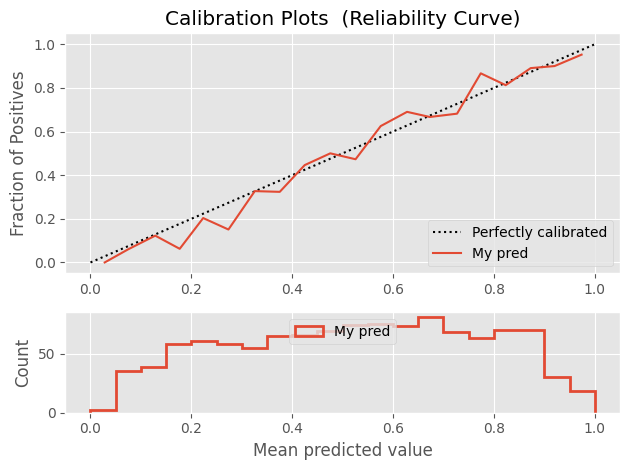

In [65]:
model_evaluate()

**Section 10: Interpretation**

In [66]:
import pickle as pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.utils import Sequence

In [67]:
# Define the paths and other parameters as variables
PATH_MODEL = "/content/drive/MyDrive/MIMIC/output/Model/weights.01.hdf5"
PATH_DATA = "/content/drive/MyDrive/MIMIC/output/data_test.pkl"
PATH_DICTIONARY = "/content/drive/MyDrive/MIMIC/output/dictionary.pkl"
BATCH_SIZE = 32

This function is used to load a pre-trained model, configure the session for its use, and create an extended version of the model that includes specific attention-related layers for additional analysis or applications.

The purpose of creating `model_with_attention` is to provide a version of the loaded model that exposes specific intermediate layers for further analysis or use. This can be helpful for tasks such as interpreting the model's internal mechanisms, visualizing attention weights, or using certain model components independently.

In [68]:
def import_model(path):
    """Import model from given path and assign it to appropriate devices"""
    K.clear_session()
    config = tf.compat.v1.ConfigProto(
        allow_soft_placement=True, log_device_placement=False
    )
    config.gpu_options.allow_growth = True
    tfsess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(tfsess)
    model = load_model(
        path,
        custom_objects={
            "FreezePadding": FreezePadding,
            "FreezePadding_Non_Negative": FreezePadding_Non_Negative,
        },
    )
    model_with_attention = Model(
        model.inputs,
        model.outputs
        + [
            model.get_layer(name="softmax_1").output,
            model.get_layer(name="beta_dense_0").output,
        ],
    )
    return model, model_with_attention

This function is used to examine and extract various aspects of the model, including the number of codes, numeric features, time features, embedding weights, output layer weights, and bias values. It can be valuable for understanding the configuration and components of a trained model, especially when further analysis or modifications are required.

In [69]:
def get_model_parameters(model):
    """Extract model arguments that were used during training"""

    class ModelParameters:
        """Helper class to store model parameters"""

        def __init__(self):
            self.num_codes = None
            self.numeric_size = None
            self.use_time = None
            self.emb_weights = None
            self.output_weights = None
            self.bias = None

    params = ModelParameters()
    names = [layer.name for layer in model.layers]
    params.num_codes = model.get_layer(name="embedding").input_dim - 1
    params.emb_weights = model.get_layer(name="embedding").get_weights()[0]
    params.output_weights, params.bias = model.get_layer(
        name="time_distributed_out"
    ).get_weights()
    print("Model bias: {}".format(params.bias))
    if "numeric_input" in names:
        params.numeric_size = model.get_layer(name="numeric_input").input_shape[2]
        # Add artificial embeddings for each numeric feature and extend the embedding weights
        # Numeric embeddings is just 1 for 1 dimension of the embedding which corresponds to taking value as is
        numeric_embeddings = np.zeros(
            (params.numeric_size, params.emb_weights.shape[1] + params.numeric_size)
        )
        for i in range(params.numeric_size):
            numeric_embeddings[i, params.emb_weights.shape[1] + i] = 1
        # Extended embedding is original embedding extended to larger output size and numerics embeddings added
        params.emb_weights = np.append(
            params.emb_weights,
            np.zeros((params.num_codes + 1, params.numeric_size)),
            axis=1,
        )
        params.emb_weights = np.append(params.emb_weights, numeric_embeddings, axis=0)
    else:
        params.numeric_size = 0
    if "time_input" in names:
        params.use_time = True
    else:
        params.use_time = False
    return params

This `SequenceBuilder` class is same as the one used in training section. But it has a different function definitions required for interpretation

In [70]:
class SequenceBuilder(Sequence):
    """Class to properly construct data to sequences

    :param Sequence: Customized Sequence class for generating batches of data
    :type Sequence: :class:`tensorflow.keras.utils.Sequence`
    """

    def __init__(self, data, model_parameters):
        # Receive all appropriate data
        self.codes = data[0]
        index = 1
        if model_parameters.numeric_size:
            self.numeric = data[index]
            index += 1

        if model_parameters.use_time:
            self.time = data[index]

        self.num_codes = model_parameters.num_codes
        self.batch_size = BATCH_SIZE
        self.numeric_size = model_parameters.numeric_size
        self.use_time = model_parameters.use_time

    def __len__(self):
        """Compute number of batches.
        Add extra batch if the data doesn't exactly divide into batches
        """
        if len(self.codes) % self.batch_size == 0:
            return len(self.codes) // self.batch_size
        return len(self.codes) // self.batch_size + 1

    def __getitem__(self, idx):
        """Get batch of specific index"""

        def pad_data(data, length_visits, length_codes, pad_value=0):
            """Pad data to desired number of visits and codes inside each visit"""
            zeros = np.full((len(data), length_visits, length_codes), pad_value)
            for steps, mat in zip(data, zeros):
                if steps != [[-1]]:
                    for step, mhot in zip(steps, mat[-len(steps) :]):
                        # Populate the data into the appropriate visit
                        mhot[: len(step)] = step

            return zeros

        # Compute reusable batch slice
        batch_slice = slice(idx * self.batch_size, (idx + 1) * self.batch_size)
        x_codes = self.codes[batch_slice]
        # Max number of visits and codes inside the visit for this batch
        pad_length_visits = max(map(len, x_codes))
        pad_length_codes = max(map(lambda x: max(map(len, x)), x_codes))
        # Number of elements in a batch (useful in case of partial batches)
        length_batch = len(x_codes)
        # Pad data
        x_codes = pad_data(x_codes, pad_length_visits, pad_length_codes, self.num_codes)
        outputs = [x_codes]
        # Add numeric data if necessary
        if self.numeric_size:
            x_numeric = self.numeric[batch_slice]
            x_numeric = pad_data(x_numeric, pad_length_visits, self.numeric_size, -99.0)
            outputs.append(x_numeric)
        # Add time data if necessary
        if self.use_time:
            x_time = sequence.pad_sequences(
                self.time[batch_slice],
                dtype=np.float32,
                maxlen=pad_length_visits,
                value=+99,
            ).reshape(length_batch, pad_length_visits, 1)
            outputs.append(x_time)

        return outputs

In [71]:
def read_data(model_parameters, path_data, path_dictionary):
    """Read test data used for scoring

    :param model_parameters: parameters of model
    :type model_parameters: str
    :param str path_data: path to test data
    :param str path_dictionary: path to code idx dictionary
    :return: tuple for data and classifier arrays
    :rtype: tuple( list[class:`numpy.ndarray`] , :class:`numpy.ndarray`)
    """

    data = pd.read_pickle(path_data)
    data_output = [data["codes"].values]

    if model_parameters.numeric_size:
        data_output.append(data["numerics"].values)
    if model_parameters.use_time:
        data_output.append(data["to_event"].values)

    with open(path_dictionary, "rb") as f:
        dictionary = pickle.load(f)

    dictionary[model_parameters.num_codes] = "PADDING"
    return data_output, dictionary

This function provides an interpretation of a patient's visits by analyzing the importance of different features (codes, numerics) during each visit. This can help in understanding the impact of these features on the patient's health over time

In [72]:
def get_importances(alphas, betas, patient_data, model_parameters, dictionary):
    """Construct dataframes that interprets each visit of the given patient"""

    importances = []
    codes = patient_data[0][0]
    index = 1
    if model_parameters.numeric_size:
        numerics = patient_data[index][0]
        index += 1

    if model_parameters.use_time:
        time = patient_data[index][0].reshape((len(codes),))
    else:
        time = np.arange(len(codes))
    for i in range(len(patient_data[0][0])):
        visit_codes = codes[i]
        visit_beta = betas[i]
        visit_alpha = alphas[i][0]
        relevant_indices = np.append(
            visit_codes,
            range(
                model_parameters.num_codes + 1,
                model_parameters.num_codes + 1 + model_parameters.numeric_size,
            ),
        ).astype(np.int32)
        values = np.full(fill_value="Diagnosed", shape=(len(visit_codes),))
        if model_parameters.numeric_size:
            visit_numerics = numerics[i]
            values = np.append(values, visit_numerics)
        values_mask = np.array(
            [1.0 if value == "Diagnosed" else value for value in values],
            dtype=np.float32,
        )
        beta_scaled = visit_beta * model_parameters.emb_weights[relevant_indices]
        output_scaled = np.dot(beta_scaled, model_parameters.output_weights)
        alpha_scaled = values_mask * visit_alpha * output_scaled
        df_visit = pd.DataFrame(
            {
                "status": values,
                "feature": [dictionary[index] for index in relevant_indices],
                "importance_feature": alpha_scaled[:, 0],
                "importance_visit": visit_alpha,
                "to_event": time[i],
            },
            columns=[
                "status",
                "feature",
                "importance_feature",
                "importance_visit",
                "to_event",
            ],
        )
        df_visit = df_visit[df_visit["feature"] != "PADDING"]
        df_visit.sort_values(["importance_feature"], ascending=False, inplace=True)
        importances.append(df_visit)

    return importances

In [73]:
def get_predictions(model, data, model_parameters):
    """Construct dataframes that interpret each visit of the given patient"""

    test_generator = SequenceBuilder(data, model_parameters)
    preds = model.predict_generator(
        generator=test_generator,
        max_queue_size=15,
        use_multiprocessing=True,
        verbose=1,
        workers=3,
    )
    return preds

In [74]:
def model_interpret():
    """Main Body of the code"""
    print("Loading Model and Extracting Parameters")
    model, model_with_attention = import_model(PATH_MODEL)
    model_parameters = get_model_parameters(model)
    print("Reading Data")
    data, dictionary = read_data(model_parameters, PATH_DATA, PATH_DICTIONARY)
    probabilities = get_predictions(model, data, model_parameters)
    BATCH_SIZE = 1
    data_generator = SequenceBuilder(data, model_parameters)
    while 1:
        patient_id = int(input("Input Patient Order Number. Type -1 to exit: "))
        if patient_id == -1:
          break
        if patient_id > len(data[0]) - 1:
            print("Invalid ID, there are only {} patients".format(len(data[0])))
        elif patient_id < 0:
            print("Only Positive IDs are accepted")
        else:
            print("Patients probability: {}".format(probabilities[patient_id, 0, 0]))
            proceed = str(input("Output predictions? (y/n): "))
            if proceed == "y":
                patient_data = data_generator.__getitem__(patient_id)
                proba, alphas, betas = model_with_attention.predict_on_batch(
                    patient_data
                )
                visits = get_importances(
                    alphas[0], betas[0], patient_data, model_parameters, dictionary
                )
                for visit in visits:
                    print(visit)

The overall structure of the output looks like this:
- Predicts the probability of death
- The patient is diagnosed with a particular ICD code (`feature`) and this feature has influenced the above prediction by the given value in `feature_importance` column.
- The patient was admitted some number of times given by `to_events` and each of these vistis importance in prediction is given by `importance_visit` column.

**example**

For 1st patient in test data. The model has predicted probability of death as 0.85. To come to this conclusion, the model used how each visit (to_event) was important for this prediction (in this case visit 1 was most influential with score of 99%) and also which particular feature (ICD9 code was important in predicting the probability) in this case D_276.2 was most influential with importance of 31.2%. At the same time other codes had influenced this prediction based on the scores they achieved.

Positive value for importance_feature suggest that these ICD9 codes took the probability values towards 1 (suggesting that these were responsible to predict that the patient would die) and negative values pulled down the probability value towards 0 (suggesting that they were responsible for predicting that the patient would not die). Since the number of positive values are more than negative values, weighted cumulative sum resulted in overall high value of 0.85 suggesting that the patient would die.

Similarly for patient in the order 25 has almost equal number of positive and negative values and weighted cumulative value resulted in probability = 0.409. This patient had visited 3 times (to_event = 0, 1, 2). to_event 2 has influenced this prediction the most with 99.9%.

**Note:** Due to splitting the data into train and test data, and random undersampling to maintain class balance, the results may vary. Patient order 30 may not be the same patient as below. (The code takes into account the order in which the patient data is stored in test set and not patient id)

In [75]:
model_interpret()

Loading Model and Extracting Parameters
Model bias: [-0.00552334]
Reading Data


<ipython-input-73-fa95821a2417>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(


36/36 [==============================] - 2s 8ms/step
Input Patient Order Number. Type -1 to exit: 1
Patients probability: 0.8250828981399536
Output predictions? (y/n): y
       status   feature  importance_feature  importance_visit  to_event
3   Diagnosed  D_427.31            0.006391          0.036584         0
2   Diagnosed   D_572.0            0.001551          0.036584         0
14  Diagnosed    D_V090            0.000665          0.036584         0
0   Diagnosed   D_038.0            0.000176          0.036584         0
5   Diagnosed   D_518.0           -0.000807          0.036584         0
8   Diagnosed  D_995.91           -0.000983          0.036584         0
1   Diagnosed   D_576.1           -0.001287          0.036584         0
7   Diagnosed   D_285.1           -0.001425          0.036584         0
4   Diagnosed     D_591           -0.002756          0.036584         0
10  Diagnosed  D_427.89           -0.003070          0.036584         0
13  Diagnosed  D_V025.9           -0.0